In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from xgboost import XGBRegressor

!pip install -q shap
import shap

!pip install -q optuna
import optuna

import os
import json
import copy

!pip install -q joblib
import joblib

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [11]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [12]:
corDefault = "#6688AA"
corViridis = ['#440154', '#414487', '#2a788e', '#22a884', '#7ad151']
colorss = ['#b2c3d4', '#414487', '#B01756']

def set_plot_style():
    # Background colors
    plt.figure().patch.set_facecolor("0.85")
    plt.axes().set(facecolor="0.85")
    
    # Hiding grid
    plt.grid(False)
    
    # Setting only left and bottom spines as visible
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Spines color
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    
    # Plot size
    plt.gcf().set_size_inches(6, 5)

    # Plot Style
    plt.style.use('seaborn-v0_8-colorblind')

# **DATASET LOADING**

In [14]:
df_train = pd.read_csv('../data/processed/02_Train.csv')

df_val = pd.read_csv('../data/processed/02_Validation.csv')

df_test = pd.read_csv('../data/processed/02_Test.csv')

df = pd.date_range(start = '2025-03-01', end = '2025-04-30', freq = 'D')
df = pd.DataFrame({'date': df})

# **DATASET SPLITTING**

In [16]:
X_train = df_train.drop('sell_quantity_log', axis = 1).copy()
y_train = df_train['sell_quantity_log'].copy()

X_val = df_val.drop('sell_quantity_log', axis = 1).copy()
y_val = df_val['sell_quantity_log'].copy()

X_test = df_test.drop('sell_quantity_log', axis = 1).copy()
y_test = df_test['sell_quantity_log'].copy()

# **MODEL DEVELOPMENT AND EVALUATION**

## **MODEL DEVELOPMENT**

In [19]:
def create_model():
    return XGBRegressor(
        n_estimators = 500,
        learning_rate = 0.05,
        max_depth = 5,
        subsample = 0.8,
        colsample_bytree = 0.8,
        random_state = 13,
        early_stopping_rounds = 20,
        eval_metric = 'rmse'
    )

def WAPE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred)) / np.sum(y_test) * 100


model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Results_1': [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]},
                          index=['MAE', 'RMSE', 'R²', 'WAPE (%)'])

metrics_df

,Results_1
MAE,0.124
RMSE,0.190
R²,0.991
WAPE (%),13.270


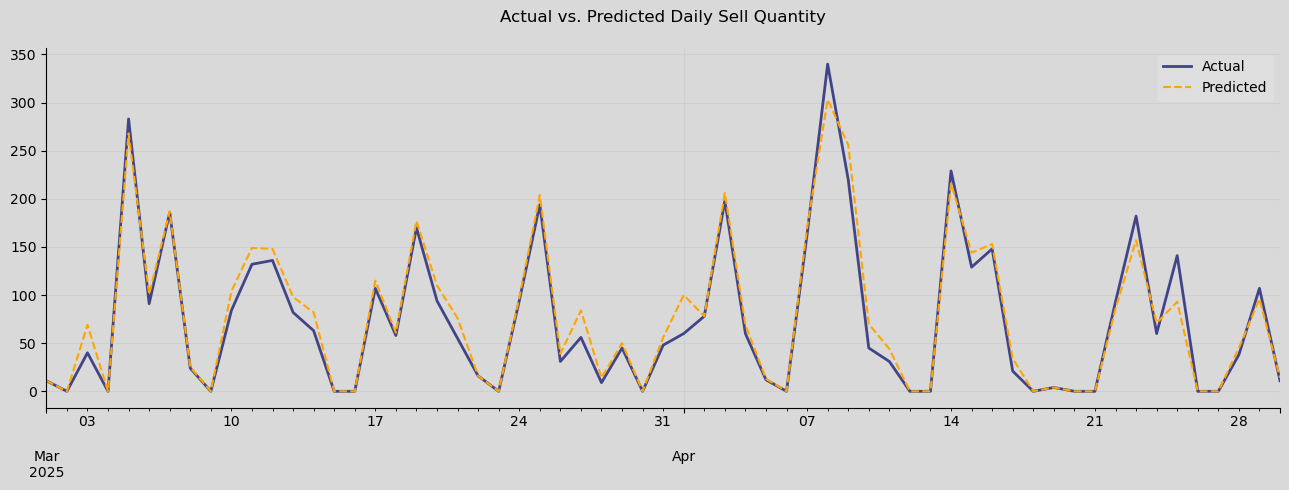

In [20]:
def PlotActPred(df, save):
    set_plot_style()
    df.set_index('date')['y_test'].plot(color = corViridis[1], linewidth = 2, label = 'Actual')
    df.set_index('date')['y_pred'].plot(color = 'orange', label = 'Predicted', linestyle = '--')
    plt.title('Actual vs. Predicted Daily Sell Quantity\n')
    legend = plt.legend()
    legend.get_frame().set_facecolor('0.88')
    legend.get_frame().set_edgecolor('0.88')
    plt.grid(visible = True, color = '0.81')
    plt.xlabel("")
    plt.ylabel("")
    plt.gcf().set_size_inches(13, 5)
    
    plt.tight_layout()
    plt.savefig(save)
    
    plt.show()
    plt.close()


PlotActPred(df, "../visuals/43.ActualvPredictedDailySellQuantity.svg")

## **MODEL REFINEMENT**

### **FEATURE IMPORTANCE**

In [23]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

result = permutation_importance(model, X_val, y_val, n_repeats = 10, random_state = 13)

xgb_importance = pd.Series(model.feature_importances_, index = X_val.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = X_val.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = X_val.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
inventory_turnover,0.510059,1.172712,7.071309e-01
sell_value,0.069037,0.281674,4.507977e-02
inventory_lag_1,0.009370,0.234526,1.458246e-02
daily_balance,0.021034,0.224093,1.528197e-01
is_weekend,0.330495,0.158705,2.847062e-02
buy_quantity,0.011788,0.151085,2.837433e-02
sell_quantity_lag_7,0.002024,0.015584,4.026138e-03
fuel_price_vs_buy_value,0.002325,0.013997,-2.856151e-05
days_until_holiday,0.007841,0.012340,-2.309280e-04
rolling_std_sell_value,0.002080,0.012246,-9.048522e-04


All three importance metrics for `fuel_price_pct_change` (XGBoost gain, SHAP, and permutation importance) returned a value of zero.

This confirms that the feature is not being utilized by the model in any meaningful way. Given its redundancy or lack of predictive contribution, we will remove this feature and retrain the model to evaluate any changes in performance.

In [25]:
X_train = X_train.drop('fuel_price_pct_change', axis = 1).copy()
X_val = X_val.drop('fuel_price_pct_change', axis = 1).copy()
X_test = X_test.drop('fuel_price_pct_change', axis = 1).copy()

In [26]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_2"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2
MAE,0.124,0.1270
RMSE,0.190,0.1920
R²,0.991,0.9908
WAPE (%),13.270,12.9210


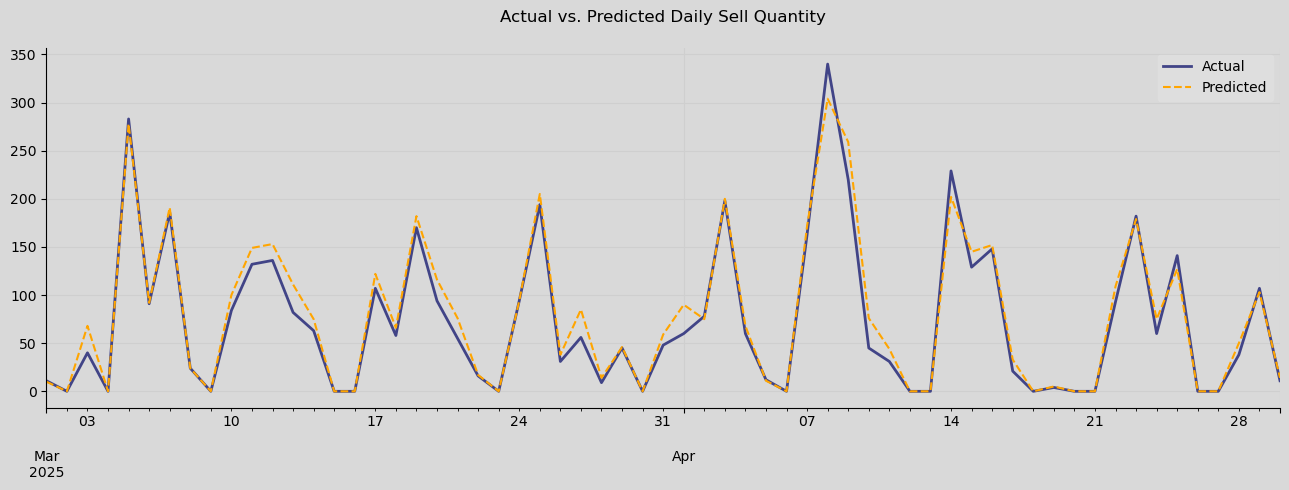

In [27]:
PlotActPred(df, "../visuals/44.ActualvPredictedDailySellQuantity.svg")

After excluding the `fuel_price_pct_change` feature, model performance slightly improved across all key metrics. This confirms that the feature was not only unused, but also introduced noise. Its removal helped the model generalize slightly better on unseen data.

In [29]:
model_v1 = copy.deepcopy(model)

### **RESIDUAL ANALYSIS**

In [31]:
df['residuals'] = df['y_test'] - df['y_pred']

df_test2 = df_test.copy()
df_test2['date'] = df['date'].copy()
df_test2['residuals'] = df['residuals'].copy()
df_test2['predicted'] = df['y_pred'].copy()
df_test2['abs_error'] = df_test2['residuals'].abs()
df_test2['y_test'] = df['y_test'].copy()

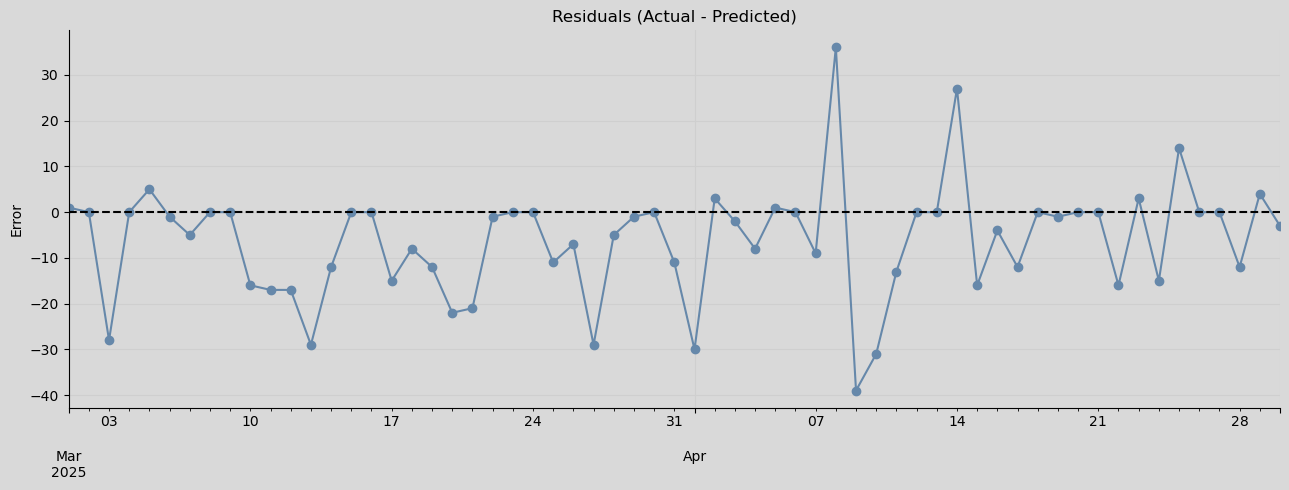

In [32]:
set_plot_style()
df_test2.set_index('date')['residuals'].plot(color = corDefault, marker = 'o', linestyle = '-')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Residuals (Actual - Predicted)')

plt.grid(visible = True, color = '0.81')
plt.xlabel("")
plt.ylabel('Error')
plt.gcf().set_size_inches(13, 5)

plt.tight_layout()
plt.savefig("../visuals/45.ResidualsPlot.svg")

plt.show()
plt.close()

We'll initiate a targeted residual analysis to better understand the conditions under which the model tends to make large prediction errors.

Throughout this phase, scatterplots with trend lines will be used to evaluate the relationship between absolute prediction error (`abs_error`) and selected features. This will guide the creation of new features (e.g., binary flags or binned categories) and the removal of others that appears to introduce noise or offer no predictive value.

Since these refinements are based on residuals from a fixed test window (March–April 2025), there is a potential risk of overfitting to this specific slice of data, to ensure that improvements generalize beyond this window, the following validation strategies will be applied after the residual-driven adjustments:
- Time-aware cross-validation or walk-forward validation on future data;
- Performance comparison with a frozen baseline model (`v1`);
- Monitoring of prediction drift or error concentration when deployed in production;
- A/B testing integrated into an operational pricing workflow.

In [34]:
cols = [
    'precipitation',
    'incc_monthly_change',
    'inventory_turnover',
    'sell_quantity_lag_7',
    'sell_value',
    'rolling_std_sell_value',
    'daily_balance',
    'buy_quantity',
    'inventory_lag_1',
    'incc_lag_2_month',
    'fuel_price_vs_buy_value',
    'fuel_price_lag_60',
    'days_until_holiday'
]

cols_desc =[
    'Impact of Precipitation on Prediction Error',
    'Model Error Across INCC Variation',
    'Prediction Error by Inventory Turnover',
    'Prediction Error vs. Prior Week’s Demand',
    'Prediction Error vs. Sell Value',
    'Model Error Across Rolling Std of Sell Value',
    'Prediction Error vs. Daily Balance',
    'Impact of Quantity Bought on Prediction Error',
    'Prediction Error vs. Prior Day’s Inventory',
    'Prediction Error vs. Two Month’s INCC Index',
    'Prediction Error by Fuel Price vs. Buy Value',
    'Prediction Error vs. Two Month’s Fuel Price',
    'Impact of Holiday Antecipation on Prediction Error'
]

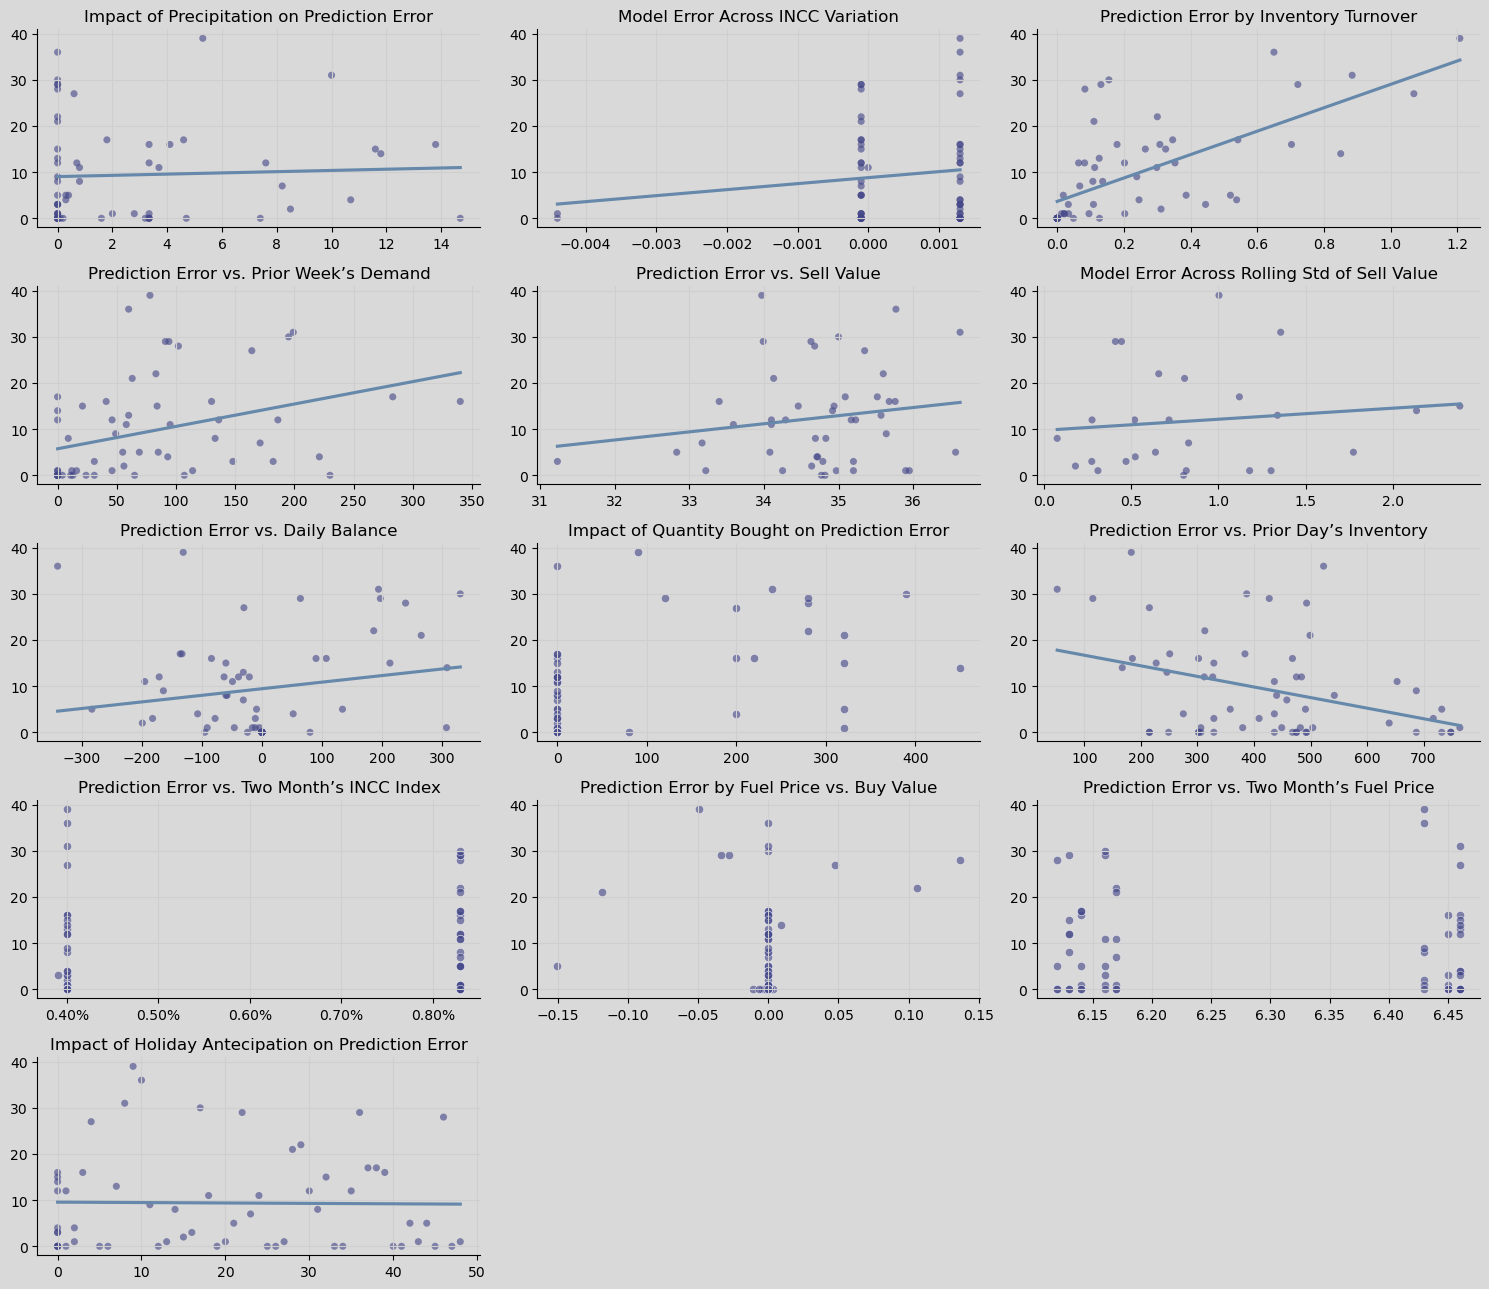

In [35]:
fig, axs = plt.subplots(5, 3, figsize = (15, 13))
fig.patch.set_facecolor("0.85")

c = int(0)
for i in range(5):
    for j in range(3):
        if ((i == 4) & (j > 0)):
            axs[i,j].axis('off')
            c += 1
        else:
            if (c == int(1) | c == int(9)):
                axs[i,j].grid(visible = True, color = '0.81')
                sns.scatterplot(data = df_test2, x = cols[c], y = 'abs_error', alpha = 0.6, ax = axs[i,j], color = corViridis[1])
                axs[i,j].set_title(cols_desc[c])
                axs[i,j].set_ylabel("")
                axs[i,j].set_xlabel("")
                axs[i,j].xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1, decimals = 2))
                axs[i,j].spines.right.set_visible(False)
                axs[i,j].spines.top.set_visible(False)
                axs[i,j].set_facecolor("0.85")
                c += 1
            elif ((c == int(7)) | ((c > int(9)) & (c <= int(11)))):
                axs[i,j].grid(visible = True, color = '0.81')
                sns.scatterplot(data = df_test2, x = cols[c], y = 'abs_error', alpha = 0.6, ax = axs[i,j], color = corViridis[1])
                axs[i,j].set_title(cols_desc[c])
                axs[i,j].set_ylabel("")
                axs[i,j].set_xlabel("")
                axs[i,j].spines.right.set_visible(False)
                axs[i,j].spines.top.set_visible(False)
                axs[i,j].set_facecolor("0.85")
                c += 1
            else:
                axs[i,j].grid(visible = True, color = '0.81')
                sns.regplot(data = df_test2, x = cols[c], y = 'abs_error', scatter = True, color = corViridis[1],
                            scatter_kws = {"s": 26, "alpha": 0.6, "edgecolors": "none"},
                            ci = True, line_kws = {"color": corDefault},
                            ax = axs[i,j])
                axs[i,j].set_title(cols_desc[c])
                axs[i,j].set_ylabel("")
                axs[i,j].set_xlabel("")
                axs[i,j].spines.right.set_visible(False)
                axs[i,j].spines.top.set_visible(False)
                axs[i,j].set_facecolor("0.85")
                c += 1

plt.tight_layout()
plt.savefig("../visuals/46.AbsoluteErrorScatterPlot.svg")
plt.show()
plt.close()

Findings:
- `precipitation`: Most high-error points occurred on dry days ($precipitation = 0$). The model does not seem to capture any demand variability related to rainfall. This feature may be redundant;
- `incc_monthly_change`: Most values are near 0%, and high-error points are spread across small positive values. There is no clear signal that this feature contributes meaningfully to prediction error. It may be safely removed or deprioritized in the model;
- `inventory_turnover`: The trend line shows a consistent upward slope, indicating growing error as turnover increases. A binned category will be created to help the model anticipate high-demand, low-stock scenarios;
- `sell_quantity_lag_7`: Although there is a slight upward trend, the pattern is weaker than initially expected. A binned category will also be created using quantiles;
- `rolling_std_sell_value`: Most errors occur when this feature is active, with no clear predictive pattern. It may introduce noise and will be removed from the model;
- `daily_balance`: Residual analysis shows that most high-error predictions occurrs when the daily balance is positive. A binary flag may be introduced to assess this;
- `buy_quantity`: While the feature in its continuous form shows little correlation with prediction error, errors are notably more severe when no purchase occurrs;
- `incc_lag_2_month`: The feature appears to offer only categorical granularity, with values clustered around two fixed points;
- `fuel_price_vs_buy_value`: The distribution of values and errors suggests this features behaves like a binary indicator. Binary flags may be introduced to assess this;
- `fuel_price_lag_60`: The feature shows low variability and no visual relationship with prediction error. The feature will be removed to evaluate its impact on the model.

In [37]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train['no_rain'] = (X_train['precipitation'] > 0.1).astype(int)
X_val['no_rain'] = (X_val['precipitation'] > 0.1).astype(int)
X_test['no_rain'] = (X_test['precipitation'] > 0.1).astype(int)

In [38]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_3"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3
MAE,0.124,0.1270,0.1080
RMSE,0.190,0.1920,0.1690
R²,0.991,0.9908,0.9929
WAPE (%),13.270,12.9210,12.0140


In [39]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

A binary flag indicating whether it had rained was created, since high-error points occurred on dry days. Since model performance worsened, it will be removed.

In [41]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train = X_train.drop('incc_monthly_change', axis = 1).copy()
X_val = X_val.drop('incc_monthly_change', axis = 1).copy()
X_test = X_test.drop('incc_monthly_change', axis = 1).copy()

In [42]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_3"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3
MAE,0.124,0.1270,0.106
RMSE,0.190,0.1920,0.168
R²,0.991,0.9908,0.993
WAPE (%),13.270,12.9210,10.670


In [43]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

Although `incc_monthly_change` initially appeared redundant based on visual analysis and had minimal impact on RMSE or R², WAPE revealed a noticeable increase (+0.43pp) upon removal. To preserve model performance and reduce relative error, this feature will be retained.

In [45]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

In [46]:
X_train['turnover_bin'] = pd.qcut(
    X_train['inventory_turnover'],
    q = 4,
    labels = [0, 1, 2 ,3]  # 0:very low, 1: low, 2: mid, 3: high
).fillna(0).astype(int)

X_val['turnover_bin'] = pd.qcut(
    X_val['inventory_turnover'],
    q = 4,
    labels = [0, 1, 2 ,3]  # 0:very low, 1: low, 2: mid, 3: high
).astype(int)

X_test['turnover_bin'] = pd.qcut(
    X_test['inventory_turnover'],
    q = 4,
    labels = [0, 1, 2 ,3]  # 0:very low, 1: low, 2: mid, 3: high
).astype(int)

In [47]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_3"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3
MAE,0.124,0.1270,0.1010
RMSE,0.190,0.1920,0.1590
R²,0.991,0.9908,0.9937
WAPE (%),13.270,12.9210,11.1050


After adding the categorical feature `turnover_bin`, and evaluating its effect on model performance, it was proved that the model benefits from having both the continuous form and its binned version. Both will be retained.

In [49]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

In [50]:
X_train['lag_7_bin'] = pd.qcut(
    X_train['sell_quantity_lag_7'],
    q = 4,
    labels = [0, 1, 2, 3]  # 0:very low, 1: low, 2: mid, 3: high
).fillna(0).astype(int)

X_val['lag_7_bin'] = pd.qcut(
    X_val['sell_quantity_lag_7'],
    q = 4,
    labels = [0, 1, 2, 3]  # 0:very low, 1: low, 2: mid, 3: high
).astype(int)

X_test['lag_7_bin'] = pd.qcut(
    X_test['sell_quantity_lag_7'],
    q = 4,
    labels = [0, 1, 2, 3]  # 0:very low, 1: low, 2: mid, 3: high
).astype(int)

In [51]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_4"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3,Results_4
MAE,0.124,0.1270,0.1010,0.1120
RMSE,0.190,0.1920,0.1590,0.1770
R²,0.991,0.9908,0.9937,0.9922
WAPE (%),13.270,12.9210,11.1050,11.5260


Adding the `lag_7_bin` feature, a binned version of prior week's demand, resulted in consistent improvements across all evaluation metrics, including a 0.39pp reduction in WAPE. This suggests that binning historical demand helps the model better generalize high and low sales patterns. The feature will be retained.

In [53]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train = X_train.drop('rolling_std_sell_value', axis = 1).copy()
X_val = X_val.drop('rolling_std_sell_value', axis = 1).copy()
X_test = X_test.drop('rolling_std_sell_value', axis = 1).copy()

In [54]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_5"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5
MAE,0.124,0.1270,0.1010,0.1120,0.1060
RMSE,0.190,0.1920,0.1590,0.1770,0.1720
R²,0.991,0.9908,0.9937,0.9922,0.9926
WAPE (%),13.270,12.9210,11.1050,11.5260,11.3590


In [55]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

Although removing `rolling_std_sell_value` initially led to a slight improvement in RMSE and R², WAPE increased in relative error (+0.23pp). Since WAPE is our primary metric, and this feature may help capture short-term price volatility, it will be retained in the final model to preserve generalization and reduce real-world prediction drift.

In [57]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train['is_positive_daily_balance'] = (X_train['daily_balance'] > 0).astype(int)
X_val['is_positive_daily_balance'] = (X_val['daily_balance'] > 0).astype(int)
X_test['is_positive_daily_balance'] = (X_test['daily_balance'] > 0).astype(int)

In [58]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_5"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5
MAE,0.124,0.1270,0.1010,0.1120,0.1090
RMSE,0.190,0.1920,0.1590,0.1770,0.1600
R²,0.991,0.9908,0.9937,0.9922,0.9936
WAPE (%),13.270,12.9210,11.1050,11.5260,12.3650


Introducing the `is_positive_daily_balance` flag resulted in consistent degradation across all evaluation metrics, including a WAPE increase of over 1pp. This suggests that the original feature already captured the relevant signal, and the binary transformation introduced redundancy or noise. The flag was discarded to preserve model performance and generalization.

In [60]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

In [61]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train['did_buy'] = (X_train['buy_quantity'] > 0).astype(int)
X_val['did_buy'] = (X_val['buy_quantity'] > 0).astype(int)
X_test['did_buy'] = (X_test['buy_quantity'] > 0).astype(int)

In [62]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_5"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5
MAE,0.124,0.1270,0.1010,0.1120,0.1110
RMSE,0.190,0.1920,0.1590,0.1770,0.1580
R²,0.991,0.9908,0.9937,0.9922,0.9937
WAPE (%),13.270,12.9210,11.1050,11.5260,12.7140


In [63]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

The `did_buy` flag, intended to capture purchase activity, led to significant degradation across all evaluation metrics, including nearly +3pp increase in WAPE. Since the original `buy_quantity` feature already encodes this signal with greater granularity, the binary flag was removed to preserve model accuracy and minimize noise.

In [65]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train = X_train.drop('buy_quantity', axis = 1).copy()
X_val = X_val.drop('buy_quantity', axis = 1).copy()
X_test = X_test.drop('buy_quantity', axis = 1).copy()

In [66]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_5"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5
MAE,0.124,0.1270,0.1010,0.1120,0.1100
RMSE,0.190,0.1920,0.1590,0.1770,0.1750
R²,0.991,0.9908,0.9937,0.9922,0.9923
WAPE (%),13.270,12.9210,11.1050,11.5260,11.4570


In [67]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

The results shows a significant decline in all performance metrics if `buy_quantity` is removed. This indicates that the continuous value of `buy_quantity` still provides meaningful signal beyond the binary flag. As a result `buy_quantity` is retained in the final model.

In [69]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train = X_train.drop('incc_lag_2_month', axis = 1).copy()
X_val = X_val.drop('incc_lag_2_month', axis = 1).copy()
X_test = X_test.drop('incc_lag_2_month', axis = 1).copy()

In [70]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_5"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5
MAE,0.124,0.1270,0.1010,0.1120,0.0920
RMSE,0.190,0.1920,0.1590,0.1770,0.1450
R²,0.991,0.9908,0.9937,0.9922,0.9947
WAPE (%),13.270,12.9210,11.1050,11.5260,9.8300


Removing `incc_lag_2_month` improved all evaluation metrics, including a significant 0.69pp drop in WAPE. This indicates that the feature either introduced noise or overlapped with other economic indicators. It will be removed to simplify the model and enhance predictive stability.

In [72]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train['fuel_vs_buy_zero'] = (X_train['fuel_price_vs_buy_value'] == 0).astype(int)
X_train['fuel_vs_buy_nonzero'] = (X_train['fuel_price_vs_buy_value'] != 0).astype(int)

X_val['fuel_vs_buy_zero'] = (X_val['fuel_price_vs_buy_value'] == 0).astype(int)
X_val['fuel_vs_buy_nonzero'] = (X_val['fuel_price_vs_buy_value'] != 0).astype(int)

X_test['fuel_vs_buy_zero'] = (X_test['fuel_price_vs_buy_value'] == 0).astype(int)
X_test['fuel_vs_buy_nonzero'] = (X_test['fuel_price_vs_buy_value'] != 0).astype(int)

In [73]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_6"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6
MAE,0.124,0.1270,0.1010,0.1120,0.0920,0.0980
RMSE,0.190,0.1920,0.1590,0.1770,0.1450,0.1460
R²,0.991,0.9908,0.9937,0.9922,0.9947,0.9947
WAPE (%),13.270,12.9210,11.1050,11.5260,9.8300,10.2280


In [74]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

The introduction of binary indicators significantly worsened model performance across all key metrics. This new features will not be used.

In [76]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train = X_train.drop('fuel_price_vs_buy_value', axis = 1).copy()
X_val = X_val.drop('fuel_price_vs_buy_value', axis = 1).copy()
X_test = X_test.drop('fuel_price_vs_buy_value', axis = 1).copy()

In [77]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_6"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6
MAE,0.124,0.1270,0.1010,0.1120,0.0920,0.095
RMSE,0.190,0.1920,0.1590,0.1770,0.1450,0.141
R²,0.991,0.9908,0.9937,0.9922,0.9947,0.995
WAPE (%),13.270,12.9210,11.1050,11.5260,9.8300,10.438


In [78]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

After testing the full removal of the feaure, we observed a consistent drop in model performance. While the feature shows limited interpretability and granularity, it appears to provide subtle signal that improves prediction quality. As a result, the original feature is retained in the final model.

In [80]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train = X_train.drop('fuel_price_lag_60', axis = 1).copy()
X_val = X_val.drop('fuel_price_lag_60', axis = 1).copy()
X_test = X_test.drop('fuel_price_lag_60', axis = 1).copy()

In [81]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_6"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6
MAE,0.124,0.1270,0.1010,0.1120,0.0920,0.1000
RMSE,0.190,0.1920,0.1590,0.1770,0.1450,0.1440
R²,0.991,0.9908,0.9937,0.9922,0.9947,0.9948
WAPE (%),13.270,12.9210,11.1050,11.5260,9.8300,10.7430


Removing `fuel_price_lag_60` resulted in a significant reduction in WAPE (-0.75pp), despite minor increases in RMSE and MAE. Since WAPE is the primary evaluation metric for this use case, the feature will be excluded from the final model to enhance relative accuracy and reduce unnecessary complexity.

### **HYPERPARAMETER TUNING**

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log = True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 3.0),
        "random_state": 13,
        "early_stopping_rounds": 20,
        "eval_metric": "rmse",
    }

    model = XGBRegressor(**params)

    model.fit(X_train, y_train,
              eval_set = [(X_val, y_val)],
              verbose = False)

    y_pred = model.predict(X_test)
    y_pred = np.maximum(y_pred, 0)

    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_test)

    return WAPE(y_true, y_pred)



study = optuna.create_study(direction = "minimize")

study.enqueue_trial({
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 1,
    "gamma": 0,
    "reg_alpha": 0,
    "reg_lambda": 1
})

study.optimize(objective, n_trials = 1000, timeout = 600)

print("**Best trial**")
print("  Value (WAPE):", study.best_trial.value)
print("  Params:", study.best_trial.params)

[I 2025-06-16 13:05:36,903] A new study created in memory with name: no-name-15b84384-253f-46c8-b06e-0bf39adc9a0e
[I 2025-06-16 13:05:37,248] Trial 0 finished with value: 10.743121020648205 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 1.0}. Best is trial 0 with value: 10.743121020648205.
[I 2025-06-16 13:05:37,281] Trial 1 finished with value: 29.920441352056326 and parameters: {'n_estimators': 693, 'learning_rate': 0.12122444117419756, 'max_depth': 7, 'subsample': 0.7963786409411047, 'colsample_bytree': 0.5172252151090955, 'min_child_weight': 2, 'gamma': 0.7894745260802993, 'reg_alpha': 0.8580040567787165, 'reg_lambda': 1.3801763764495574}. Best is trial 0 with value: 10.743121020648205.
[I 2025-06-16 13:05:37,317] Trial 2 finished with value: 40.40208777074711 and parameters: {'n_estimators': 519, 'learning_rate': 0.051936169075707944, 'max_d

In [ ]:
model = XGBRegressor(
    n_estimators = 346,
    learning_rate = 0.09991729072752244,
    max_depth = 5,
    subsample = 0.9532236558053172,
    colsample_bytree = 0.8417591298933222,
    min_child_weight = 6,
    gamma = 0.0028081316750468172,
    reg_alpha = 0.04422947536724138,
    reg_lambda = 1.0609399138290971,
        random_state = 13,
        early_stopping_rounds = 20,
        eval_metric = 'rmse'
)

model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_7"] = [np.round(mae, 3), np.round(rmse, 3), np.round(r2, 4), np.round(WAPE(np.expm1(y_test), np.expm1(y_pred)), 3)]
metrics_df

In [ ]:
PlotActPred(df, "../visuals/47.ActualvPredictedDailySellQuantity.svg")

# **MODEL VERSIONING AND TRACKING**

## **VERSION 1**

In [ ]:
X_train.info()

In [80]:
model_v1_meta = {
    "version": "v1",
    "description": "Baseline model trained after EDA and feature importance, with removal of low-impact feature `fuel_price_pct_change`. Used as benchmark for residual analysis phase.",
    "trained_on": "2024-01-01 to 2024-12-31",
    "validated_on": "2025-01-01 to 2025-02-28",
    "tested_on": "2025-03-01 to 2025-04-30",
    "features": [
        "sell_value",
        "sell_quantity_lag_7",
        "rolling_std_sell_value",
        "daily_balance",
        "inventory_turnover",
        "buy_quantity",
        "inventory_lag_1",
        "precipitation",
        "incc_monthly_change",
        "incc_lag_2_month",
        "fuel_price_vs_buy_value",
        "fuel_price_lag_60",
        "is_weekend",
        "days_until_holiday",
        "month"
    ],
    "metrics_test_set": {
        "MAE": 0.1090,
        "RMSE": 0.1700,
        "R2": 0.9928,
        "WAPE (%)": 12.2710
        
    },
    "notebook_origin": "Modeling.ipynb",
    "tag": "baseline_v1_after_feature_importance",
    "created_by": "Fábio Galdino",
    "created_at": "2025-06-15"
}

In [81]:
os.makedirs("../models", exist_ok = True)

joblib.dump(model_v1, "../models/model_v1.pkl")
with open("../models/model_v1_meta.json", "w") as f:
    json.dump(model_v1_meta, f, indent = 4)

## **VERSION 2**

In [83]:
model_v2_meta = {
    "version": "v2",
    "description": "Refined and optimized model using residual analysis and WAPE as primary metric, followed by Optuna hyperparameter tuning. Final feature set includes engineered bins and relevant predictors retained through performance validation.",
    "trained_on": "2024-01-01 to 2024-12-31",
    "validated_on": "2025-01-01 to 2025-02-28",
    "tested_on": "2025-03-01 to 2025-04-30",
    "features": [
        "sell_value",
        "sell_quantity_lag_7",
        "rolling_std_sell_value",
        "daily_balance",
        "inventory_turnover",
        "buy_quantity",
        "inventory_lag_1",
        "precipitation",
        "incc_monthly_change",
        "fuel_price_vs_buy_value",
        "is_weekend",
        "days_until_holiday",
        "month",
        "turnover_bin",
        "lag_7_bin"
    ],
    "metrics_test_set": {
        "MAE": 0.0870,
        "RMSE": 0.1340,
        "R2": 0.9955,
        "WAPE (%)": 8.3220
    },
    "removed_features": [
        "incc_lag_2_month",
        "fuel_price_lag_60"
    ],
    "created_features": [
        "turnover_bin",
        "lag_7_bin"
    ],
    "notebook_origin": "Modeling.ipynb",
    "tag": "residual_analysis_v2_optuna",
    "created_by": "Fábio Galdino",
    "created_at": "2025-06-16"
}

In [84]:
joblib.dump(model, "../models/model_v2.pkl")
with open("../models/model_v2_meta.json", "w") as f:
    json.dump(model_v2_meta, f, indent = 4)

# **SAVING PROCESSED DATASET**

In [86]:
df_train = X_train.copy()
df_train['sell_quantity_log'] = y_train

df_val = X_val.copy()
df_val['sell_quantity_log'] = y_val

df_test = X_test.copy()
df_test['sell_quantity_log'] = y_test

In [87]:
df_train.to_csv('../data/processed/03_Train.csv', index = False)
df_val.to_csv('../data/processed/03_Validation.csv', index = False)
df_test.to_csv('../data/processed/03_Test.csv', index = False)

# **FINAL REMARKS AND NEXT STEPS**

This notebook concludes the development of the v2 demand forecasting model using XGBoost, enhanced through targeted residual analysis and refined via Optuna-based hyperparameter tuning. Feature engineering decisions were guided by model error patterns, with WAPE adopted as the primary evaluation metric to reflect proportional prediction quality.

Although the refinements were based on a fixed test window (March–April 2025), safeguards are already in place to ensure generalization, including:
- A/B testing between v2 and the frozen v1 baseline in a real-world pricing environment;
- Time-aware validation and monitoring of performance on future data;
- Tracking of prediction drift and anomaly concentration in production;
- Model versioning to maintain reproducibility and traceability.

With the demand model now finalized, the next step is to apply its forecasts to a profit margin optimization layer, enabling dynamic pricing decisions driven by predicted demand behavior.

# **AUTHOR**

## Fábio Galdino